# Data Processing

In [5]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import BayesianRidge
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RepeatedKFold

import shap
import warnings
warnings.filterwarnings('ignore')

In [6]:
rent = pd.read_csv ('data/zori_county.csv')

In [7]:
rent.drop (columns = ["RegionID", "SizeRank", "StateCodeFIPS", "MunicipalCodeFIPS", "RegionType", "StateName"], inplace = True)

In [8]:
#use the melt function to transpose columns to rows
rent = rent.melt(id_vars=['RegionName', 'State', 'Metro'])

In [9]:
#renaming and cleanup
rent.rename (columns = {"variable": "month", "value" : "median_rent", "RegionName" : "county", "State" : "state", "Metro" : "metro"}, inplace = True)
rent["month"] = pd.to_datetime (rent ["month"])
rent["month"] = rent["month"].apply(lambda x: x.replace(day=1))

#filter the data for only 2020-2023 rows
rent = rent [(rent ["month"] > '2020-01-01') & (rent ["month"] <= '2023-12-01')]

In [10]:
print (len(rent))
rent.head ()

54285


,county,state,metro,month,median_rent
70455,Los Angeles County,CA,"Los Angeles-Long Beach-Anaheim, CA",2020-02-01,2379.831840
70456,Cook County,IL,"Chicago-Naperville-Elgin, IL-IN-WI",2020-02-01,1731.417599
70457,Harris County,TX,"Houston-The Woodlands-Sugar Land, TX",2020-02-01,1386.122902
70458,Maricopa County,AZ,"Phoenix-Mesa-Chandler, AZ",2020-02-01,1362.442188
70459,San Diego County,CA,"San Diego-Chula Vista-Carlsbad, CA",2020-02-01,2210.282441


In [11]:
rent.isna().sum()

county             0
state              0
metro           2585
month              0
median_rent    22273
dtype: int64

In [12]:
rent = rent.dropna(subset=['median_rent'])

I downloaded Redfin's county level housing sales data from https://www.redfin.com/news/data-center/. The big challenge with using this data extract was the size of the dataset. It consisted of Xm rows of data spanning ten years. In order to extract the period that is relevant to this project, I used pandas to read the tab separate file, filter the data, and then saved it back for future use.

In [13]:
housing = pd.read_csv('data/redfin_data.csv')

In [14]:
#filter to all residential types for now, and get only relevant columns
housing = housing [["period_begin", "region", "state_code",
                             "avg_sale_to_list", "median_dom", "median_ppsf", "new_listings", "pending_sales", "median_list_price", 
                            "median_sale_price", "months_of_supply"]]

In [15]:
#rename columns and some basic cleanup
housing.rename (columns = {"period_begin" : "month", "state_code" : "state", "region" : "county"}, inplace = True)
housing["county"] = housing ["county"].str.split(',').str[0]
housing["month"] = pd.to_datetime (housing ["month"])
print (len (housing))
pd.options.display.max_columns = None
housing.head ()


151727


,month,county,state,avg_sale_to_list,median_dom,median_ppsf,new_listings,pending_sales,median_list_price,median_sale_price,months_of_supply
0,2023-01-01,Iowa County,IA,0.996708,36.0,123.019563,4.0,6.0,228700.0,197500.0,2.2
1,2024-01-01,Chouteau County,MT,NaN,1447.0,164.101891,1.0,NaN,155000.0,624900.0,13.0
2,2021-05-01,Fergus County,MT,NaN,123.0,210.000000,1.0,NaN,569000.0,369900.0,0.8
3,2023-08-01,Weld County,CO,0.992977,44.0,200.560103,552.0,418.0,493500.0,499900.0,2.9
4,2023-10-01,Will County,IL,1.000580,49.0,177.240122,684.0,633.0,325000.0,315000.0,2.4


In [16]:
#join the housing sales data into the rent dataset
rent_merged =  pd.merge(rent, housing, on = ["month", "county", "state"], how = "inner")
rent_merged.head()

,county,state,metro,month,median_rent,avg_sale_to_list,median_dom,median_ppsf,new_listings,pending_sales,median_list_price,median_sale_price,months_of_supply
0,Los Angeles County,CA,"Los Angeles-Long Beach-Anaheim, CA",2020-02-01,2379.831840,0.996496,49.0,434.540390,6685.0,4049.0,699900.0,635000.0,3.1
1,Cook County,IL,"Chicago-Naperville-Elgin, IL-IN-WI",2020-02-01,1731.417599,0.968483,73.0,157.208445,7669.0,4615.0,304000.0,242000.0,4.5
2,Harris County,TX,"Houston-The Woodlands-Sugar Land, TX",2020-02-01,1386.122902,0.972165,55.0,111.162181,5726.0,3456.0,250000.0,230000.0,3.9
3,Maricopa County,AZ,"Phoenix-Mesa-Chandler, AZ",2020-02-01,1362.442188,0.985939,41.0,174.431221,7741.0,5949.0,328146.5,310000.0,2.1
4,San Diego County,CA,"San Diego-Chula Vista-Carlsbad, CA",2020-02-01,2210.282441,0.989691,29.0,378.202584,3392.0,2656.0,639000.0,600000.0,2.0


In [17]:
countypop = pd.read_csv('data/population_county.csv')

In [18]:
countypop.rename (columns = {"Rural_Urban_Continuum_Code_2023" : "rural_urban_code", "Urban_Influence_2013" : "urban_type"}, inplace = True)
countypop.drop (columns = ["Economic_typology_2015", "CENSUS_2020_POP", "ESTIMATES_BASE_2020"], inplace = True)

countypop = countypop.loc[:,~countypop.columns.str.startswith('R_')]
countypop = countypop.loc[:,~countypop.columns.str.startswith('GQ_')]
countypop = countypop.loc[:,~countypop.columns.str.startswith('RESIDUAL_')]

In [19]:
countypop.rename (columns = {"Area_Name" : "county", "State" : "state"}, inplace = True)
countypop.columns = [x.lower() for x in countypop.columns]
countypop.head()

,fipstxt,state,county,rural_urban_continuum_code_2013,rural_urban_code,urban_type,pop_estimate_2020,pop_estimate_2021,pop_estimate_2022,pop_estimate_2023,n_pop_chg_2020,n_pop_chg_2021,n_pop_chg_2022,n_pop_chg_2023,births_2020,births_2021,births_2022,births_2023,deaths_2020,deaths_2021,deaths_2022,deaths_2023,natural_chg_2020,natural_chg_2021,natural_chg_2022,natural_chg_2023,international_mig_2020,international_mig_2021,international_mig_2022,international_mig_2023,domestic_mig_2020,domestic_mig_2021,domestic_mig_2022,domestic_mig_2023,net_mig_2020,net_mig_2021,net_mig_2022,net_mig_2023
0,1001,AL,Autauga County,2.0,2.0,2.0,"58,915","59,203","59,726","60,342",106,288,523,616,162,686,706,714,176,696,687,621,-14,-10,19,93,0.0,15,22,34,100,242,507,491,100,257,529,525
1,1003,AL,Baldwin County,3.0,3.0,2.0,"233,227","239,439","246,531","253,507","1,459","6,212","7,092","6,976",560,"2,337","2,511","2,531",602,"2,948","3,022","2,640",-42,-611,-511,-109,11.0,105,250,291,"1,613","6,972","7,036","6,804","1,624","7,077","7,286","7,095"
2,1005,AL,Barbour County,6.0,6.0,6.0,"24,969","24,533","24,700","24,585",-260,-436,167,-115,60,270,278,267,92,390,363,350,-32,-120,-85,-83,0.0,0,2,13,-186,-313,237,-45,-186,-313,239,-32
3,1007,AL,Bibb County,1.0,1.0,1.0,"22,188","22,359","21,986","21,868",-113,171,-373,-118,56,240,236,240,55,325,314,290,1,-85,-78,-50,0.0,1,1,1,-101,254,-303,-69,-101,255,-302,-68
4,1009,AL,Blount County,1.0,1.0,1.0,"59,107","59,079","59,516","59,816",-23,-28,437,300,137,654,693,698,199,875,846,776,-62,-221,-153,-78,1.0,9,8,24,21,141,589,358,22,150,597,382


In [20]:
#the county level data is in column format, make it row-wise and apply it to each year
countypop_combined = pd.DataFrame ()

for year in range (2020, 2024, 1):
    cols = countypop.columns [countypop.columns.str.contains (str(year))].tolist()
    cols = list(["state", "county", "rural_urban_code", "urban_type"]) + cols
    #print (cols)
    
    countypop_year = countypop [cols]
    countypop_year.columns = [c.replace("_" + str(year), "") for c in list(countypop_year.columns)]
    countypop_year ["month"] = pd.to_datetime (str(year) + "-01-01")
    #print (countypop_year.columns)

    countypop_combined = pd.concat ([countypop_combined, countypop_year])


countypop_combined.drop (columns = ["n_pop_chg", "births", "deaths", "international_mig", "domestic_mig"], inplace = True)
countypop_combined ["pop_estimate"] = pd.to_numeric(countypop_combined ["pop_estimate"].str.replace(',',''), errors='coerce')
countypop_combined ["natural_chg"] = pd.to_numeric(countypop_combined ["natural_chg"].str.replace(',',''), errors='coerce')
countypop_combined ["net_mig"] = pd.to_numeric(countypop_combined ["net_mig"].str.replace(',',''), errors='coerce')

pd.options.display.max_columns = None
countypop_combined.head()



,state,county,rural_urban_code,urban_type,pop_estimate,natural_chg,net_mig,month
0,AL,Autauga County,2.0,2.0,58915.0,-14.0,100.0,2020-01-01
1,AL,Baldwin County,3.0,2.0,233227.0,-42.0,1624.0,2020-01-01
2,AL,Barbour County,6.0,6.0,24969.0,-32.0,-186.0,2020-01-01
3,AL,Bibb County,1.0,1.0,22188.0,1.0,-101.0,2020-01-01
4,AL,Blount County,1.0,1.0,59107.0,-62.0,22.0,2020-01-01


In [21]:
rent_enriched =  pd.merge(rent_merged.assign(grouper=rent_merged['month'].dt.to_period('Y')), 
                     countypop_combined.assign(grouper=countypop_combined['month'].dt.to_period('Y')), 
                         on = ["grouper", "county", "state"], how = "inner")

rent_enriched.drop (columns = ["month_y", "grouper"], inplace = True)
rent_enriched.rename (columns = {"month_x": "month"}, inplace = True)
rent_enriched.head()


,county,state,metro,month,median_rent,avg_sale_to_list,median_dom,median_ppsf,new_listings,pending_sales,median_list_price,median_sale_price,months_of_supply,rural_urban_code,urban_type,pop_estimate,natural_chg,net_mig
0,Los Angeles County,CA,"Los Angeles-Long Beach-Anaheim, CA",2020-02-01,2379.831840,0.996496,49.0,434.540390,6685.0,4049.0,699900.0,635000.0,3.1,1.0,1.0,9992813.0,3845.0,-25335.0
1,Los Angeles County,CA,"Los Angeles-Long Beach-Anaheim, CA",2020-03-01,2380.162607,1.002147,41.0,440.816327,6197.0,4581.0,696000.0,660000.0,2.6,1.0,1.0,9992813.0,3845.0,-25335.0
2,Los Angeles County,CA,"Los Angeles-Long Beach-Anaheim, CA",2020-04-01,2371.452016,1.000256,38.0,430.261294,4394.0,3405.0,675000.0,650000.0,3.5,1.0,1.0,9992813.0,3845.0,-25335.0
3,Los Angeles County,CA,"Los Angeles-Long Beach-Anaheim, CA",2020-05-01,2361.831612,0.992456,44.0,432.357043,6396.0,3842.0,738000.0,635000.0,4.7,1.0,1.0,9992813.0,3845.0,-25335.0
4,Los Angeles County,CA,"Los Angeles-Long Beach-Anaheim, CA",2020-06-01,2355.978817,0.993162,43.0,434.108527,7287.0,4870.0,740000.0,655000.0,3.4,1.0,1.0,9992813.0,3845.0,-25335.0


In [22]:
#filter the data to exlcude big metros
rent_enriched = rent_enriched [rent_enriched["rural_urban_code"] > 2]

#filter the data to exlcude very small towns
rent_enriched = rent_enriched [rent_enriched["pop_estimate"] > 100000]


In [23]:
#interest rates data
interest_rates = pd.read_csv ("data/interest_rates.csv")

In [24]:
interest_rates["month"] = pd.to_datetime(interest_rates["month"])
interest_rates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   month          48 non-null     datetime64[ns]
 1   interest_rate  48 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 900.0 bytes


In [25]:
rent_enriched =  pd.merge(rent_enriched, interest_rates, 
                         on = ["month"], how = "left")


In [26]:
rent_enriched.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5356 entries, 0 to 5355
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   county             5356 non-null   object        
 1   state              5356 non-null   object        
 2   metro              5356 non-null   object        
 3   month              5356 non-null   datetime64[ns]
 4   median_rent        5356 non-null   float64       
 5   avg_sale_to_list   5059 non-null   float64       
 6   median_dom         5356 non-null   float64       
 7   median_ppsf        5356 non-null   float64       
 8   new_listings       5356 non-null   float64       
 9   pending_sales      5356 non-null   float64       
 10  median_list_price  5356 non-null   float64       
 11  median_sale_price  5356 non-null   float64       
 12  months_of_supply   5356 non-null   float64       
 13  rural_urban_code   5356 non-null   float64       
 14  urban_ty

In [27]:
rent_enriched.county.nunique()

141

In [28]:
rent_enriched.isnull().sum()

county                 0
state                  0
metro                  0
month                  0
median_rent            0
avg_sale_to_list     297
median_dom             0
median_ppsf            0
new_listings           0
pending_sales          0
median_list_price      0
median_sale_price      0
months_of_supply       0
rural_urban_code       0
urban_type             0
pop_estimate           0
natural_chg            0
net_mig                0
interest_rate          0
dtype: int64

In [29]:
rent_enriched = rent_enriched.dropna(subset=['median_list_price', 'median_ppsf'])
rent_enriched['avg_sale_to_list'] = rent_enriched['avg_sale_to_list'].fillna(1)
rent_enriched['new_listings'] = rent_enriched['new_listings'].fillna(0)
rent_enriched['pending_sales'] = rent_enriched['pending_sales'].fillna(0)
rent_enriched['months_of_supply'] = rent_enriched['months_of_supply'].fillna(0)

In [30]:
rent_current = rent_enriched [rent_enriched ["month"] == "2023-12-01"]

# Exploratory Data Analysis

Text(0.5, 0, 'Month')

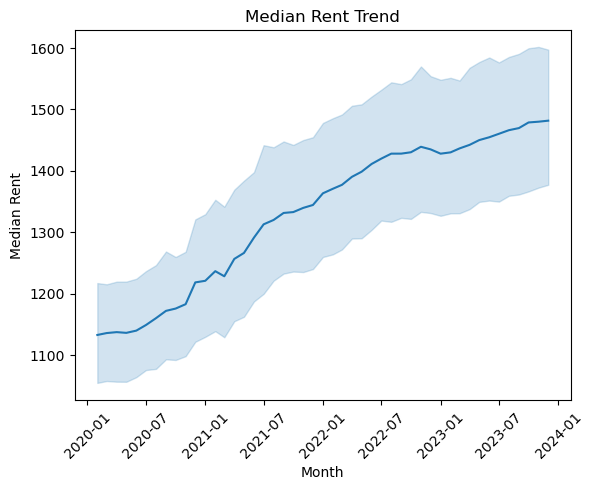

In [35]:
ax = sns.lineplot (data = rent_enriched.groupby(["state", "month"])["median_rent"].mean ().reset_index(), x = "month", y = "median_rent")
ax.tick_params(axis='x', rotation=45)
plt.title ("Median Rent Trend")
plt.ylabel('Median Rent')
plt.xlabel('Month')

Text(0.5, 0, 'Month')

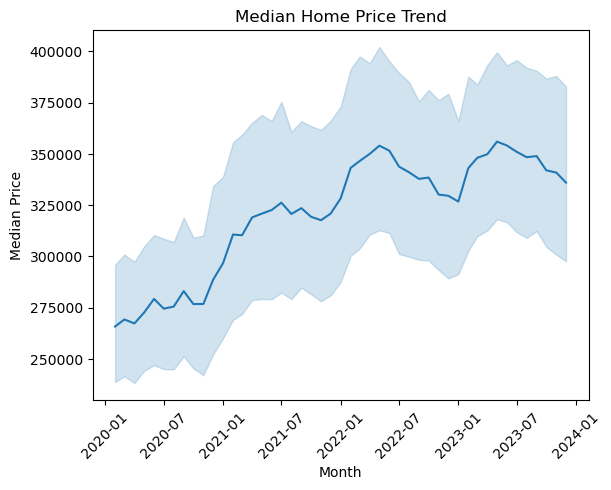

In [36]:
ax = sns.lineplot (data = rent_enriched.groupby(["state", "month"])["median_list_price"].mean ().reset_index(), x = "month", y = "median_list_price")
ax.tick_params(axis='x', rotation=45)
plt.title ("Median Home Price Trend")
plt.ylabel('Median Price')
plt.xlabel('Month')

<Axes: xlabel='pop_estimate', ylabel='median_rent'>

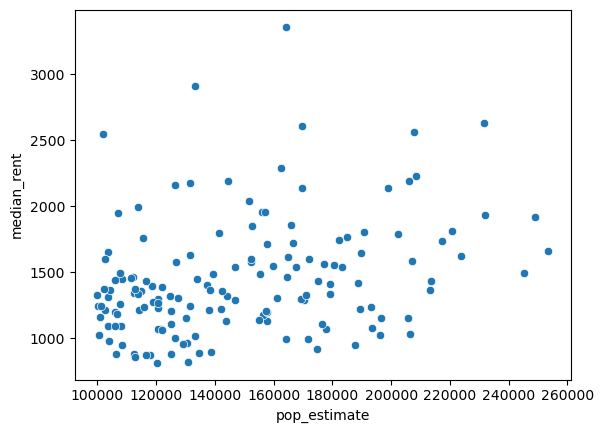

In [55]:
sns.scatterplot (data = rent_current, x = "pop_estimate", y = "median_rent")

<Axes: xlabel='median_ppsf', ylabel='median_rent'>

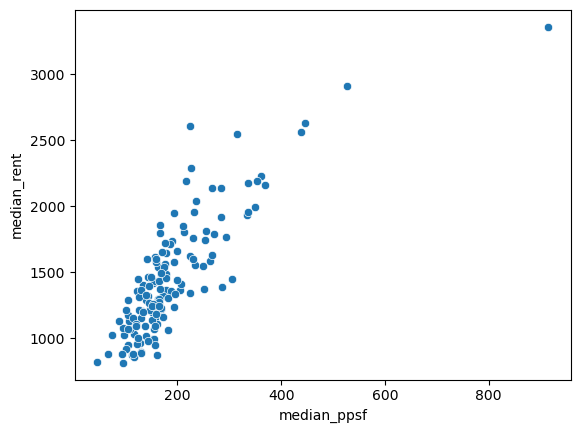

In [57]:
sns.scatterplot (data = rent_current, x = "median_ppsf", y = "median_rent")

<Axes: xlabel='median_list_price', ylabel='median_rent'>

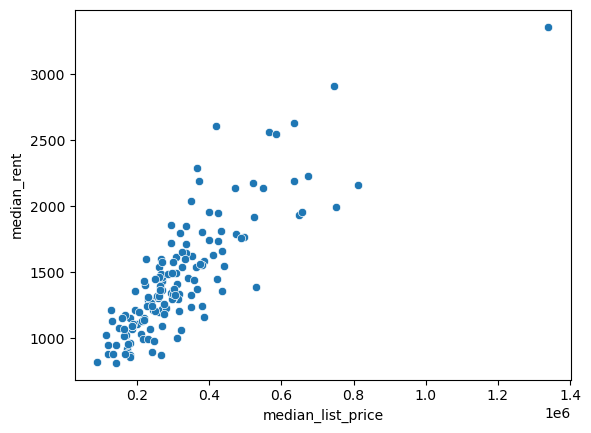

In [39]:
sns.scatterplot (data = rent_current, x = "median_list_price", y = "median_rent")

<Axes: >

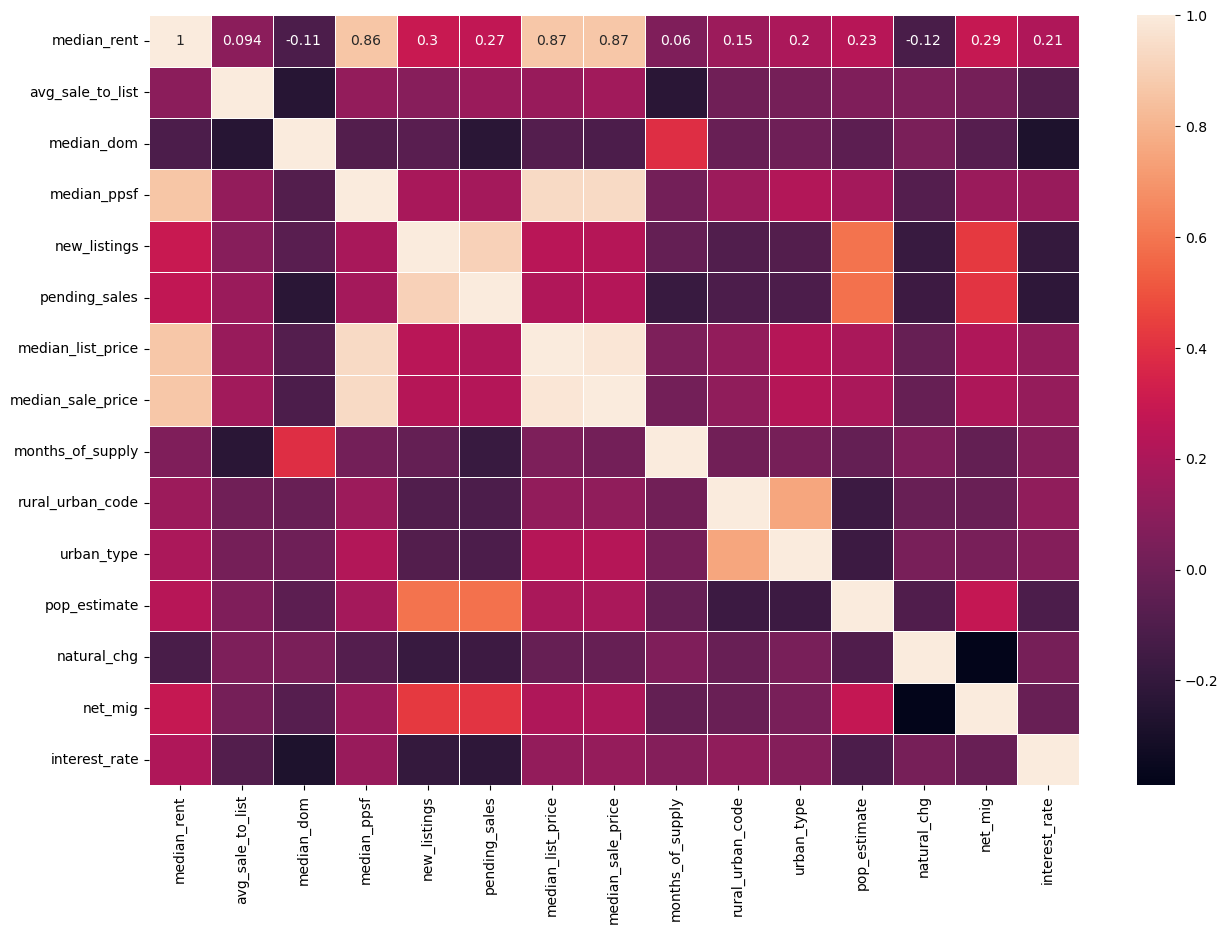

In [58]:
corr = rent_enriched.select_dtypes('number').corr()

# plot the heatmap
plt.subplots(figsize=(15, 10))
sns.heatmap(corr, annot=True, cbar=True, linewidths=.5)

# Model Selection and Training

In [31]:
# Split the data into training and testing sets
X = rent_enriched.drop (columns = ["month", "county", "metro", "median_rent"])
y = rent_enriched['median_rent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
scaler = make_column_transformer((OneHotEncoder(),['state']),remainder= StandardScaler ())

In [33]:
#DummyClassifier
dc = DummyRegressor ()
dc.fit (X_train, y_train)
dc_score = dc.score (X_test, y_test)
print (dc_score)

-6.645972533414479e-06


## Linear Regression

In [36]:
lr_pipe = Pipeline([
    ('scaler', scaler),
    ('lr', LinearRegression())
])
lr_pipe.fit (X_train, y_train)

Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['state'])])),
                ('lr', LinearRegression())])

In [37]:
lr_test_score = lr_pipe.score (X_test, y_test)
print (lr_test_score)

0.8953025051142026


## KNN

In [38]:
knn_params = {
    'knn__n_neighbors':[3,5,10,20],
    'knn__weights':['uniform', 'distance'],
    'knn__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
    'knn__leaf_size':[5,10,20,30,40,50,100],
    'knn__p':[1,2]
}

knn_pipe = Pipeline([
    ('scaler', scaler),
    ('knn', KNeighborsRegressor())
])

#knn_gs = GridSearchCV(knn_pipe, param_grid = knn_params, cv=5)
#knn_gs.fit(X_train, y_train)
#knn_best = knn_gs.best_estimator_
#print("Best Params {}".format(knn_gs.best_params_))
#Best Params {'knn__algorithm': 'auto', 'knn__leaf_size': 5, 'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'distance'}

knn_best = Pipeline([
    ('scaler', scaler),
    ('knn', KNeighborsRegressor(leaf_size = 5, p = 1, weights = 'distance', n_neighbors = 3))
]).fit (X_train, y_train)

In [39]:
knn_train_score = knn_best.score (X_train, y_train)
print (knn_train_score)

knn_test_score = knn_best.score (X_test, y_test)
print (knn_test_score)

1.0
0.9905950816717721


## Decision Trees

In [40]:
dt_params = { 
    'dt__criterion':['friedman_mse', 'poisson', 'absolute_error', 'squared_error'],
    'dt__max_depth': np.arange(3, 15)
}

dt_pipe = Pipeline([
    ('scaler', scaler),
    ('dt', DecisionTreeRegressor())
])

#dt_gs = GridSearchCV(dt_pipe, param_grid = dt_params, cv = 5)
#dt_gs.fit(X_train, y_train)
#print("Best Params {}".format(dt_gs.best_params_))
#dt_best = dt_gs.best_estimator_
#Best Params {'dt__criterion': 'poisson', 'dt__max_depth': 14}

dt_best = Pipeline([
    ('scaler', scaler),
    ('dt', DecisionTreeRegressor(max_depth = 14, criterion = 'poisson' ))
]).fit (X_train, y_train)


In [41]:
dt_train_score = dt_best.score (X_train, y_train)
print (dt_train_score)

dt_test_score = dt_best.score (X_test, y_test)
print (dt_test_score)

0.9948875413701106
0.9569040786520728


## SVM

In [42]:
svm_pipe = Pipeline([
    ('scaler', scaler),
    ('svm', SVR())
])

svm_params = {
    'svm__kernel' : ('linear', 'poly', 'rbf', 'sigmoid'),
    'svm__C' : [1,5,10],
    'svm__degree' : [3,8],
    'svm__coef0' : [0.01,10,0.5],
    'svm__gamma' : ('auto','scale')},

#svm_gs = GridSearchCV(svm_pipe, param_grid = svm_params, cv = 5)
#svm_gs.fit(X_train, y_train)
#print("Best Params {}".format(svm_gs.best_params_))

svm_best = Pipeline([
    ('scaler', scaler),
    ('dt', SVR())
]).fit (X_train, y_train)

In [43]:
svm_train_score = svm_best.score (X_train, y_train)
print (svm_train_score)

svm_test_score = svm_best.score (X_test, y_test)
print (svm_test_score)

0.39109048164666227
0.4076088301262799


## Random Forest

In [44]:
rf_pipe = Pipeline([
    ('scaler', scaler),
    ('rf', RandomForestRegressor())
])

rf_params = {
    'rf__n_estimators': [100, 200],
    'rf__min_samples_split': [8, 10],
    'rf__min_samples_leaf': [3, 4, 5],
    'rf__max_depth': [80, 90]
}


# try out every combination of the above values
#rf_gs = GridSearchCV (rf_pipe, rf_params, cv = 5)
#rf_gs.fit (X_train, y_train)

#print("Best Params {}".format(rf_gs.best_params_))

rf_pipe.fit (X_train, y_train)


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder=StandardScaler(),
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['state'])])),
                ('rf', RandomForestRegressor())])

In [45]:
rf_test_score = rf_pipe.score (X_test, y_test)

## ElasticNet

In [46]:
enet_pipe = Pipeline([
    ('scaler', scaler),
    ('enet', ElasticNet())
])

enet_params = {
    'enet__alpha'     : [0.1,1,10,0.01],
    'enet__l1_ratio'  :  np.arange(0.40,1.00,0.10),
    'enet__tol'       : [0.0001,0.001]
}

# try out every combination of the above values
enet_gs = GridSearchCV (enet_pipe, enet_params, scoring='roc_auc', cv = 5)
enet_gs.fit (X_train, y_train)
print("Best Params {}".format(enet_gs.best_params_))
enet_best = enet_gs.best_estimator_
#Best Params {'enet__alpha': 0.1, 'enet__l1_ratio': 0.4, 'enet__tol': 0.0001}

#enet_best = Pipeline([
#    ('scaler', scaler),
#    ('enet', ElasticNet(alpha = 0.1, l1_ratio = 0.4, tol = 0.0001))
#]).fit(X_train, y_train)

Best Params {'enet__alpha': 0.1, 'enet__l1_ratio': 0.4, 'enet__tol': 0.0001}


In [47]:
enet_train_score = enet_best.score (X_train, y_train)
print (enet_train_score)

enet_test_score = enet_best.score (X_test, y_test)
print (enet_test_score)

0.8537024074521757
0.839315169647176


## GradientBoostingRegressor

In [48]:
gb_pipe = Pipeline([
    ('scaler', scaler),
    ('gb', GradientBoostingRegressor())
])

gb_params = {
    'gb__n_estimators'     : [0.1,1,10,0.01],
    'gb__learning_rate'  :  [0.0001, 0.001, 0.01, 0.1, 1.0],
    'gb__subsample'       : [0.5, 0.7, 1.0],
    'gb__max_depth'       : [3, 7, 9]
}

# try out every combination of the above values
#gb_gs = GridSearchCV (gb_pipe, gb_params, cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1))
#gb_gs.fit (X_train, y_train)
#gb_best = gb_gs.best_estimator_
#print("Best Params {}".format(gb_gs.best_params_))
#Best Params {'gb__learning_rate': 1.0, 'gb__max_depth': 7, 'gb__n_estimators': 10, 'gb__subsample': 1.0}

gb_best = Pipeline([
    ('scaler', scaler),
    ('gb', GradientBoostingRegressor(learning_rate = 1, max_depth = 7, n_estimators = 10, subsample = 1))
]).fit (X_train, y_train)


In [49]:
gb_train_score = gb_best.score (X_train, y_train)
print (gb_train_score)

gb_test_score = gb_best.score (X_test, y_test)
print (gb_test_score)

0.9867026060760824
0.9477382559575436


## XgBoost

In [50]:
xgb_pipe = Pipeline([
    ('scaler', scaler),
    ('xgb', xgb.XGBRegressor(eval_metric='rmsle'))
])

xgb_params = {
    "xgb__max_depth":    [4, 5, 6],
    "xgb__n_estimators": [500, 600, 700],
    "xgb__learning_rate": [0.01, 0.015]
}

# try out every combination of the above values
#xgb_gs = GridSearchCV(xgb_pipe, xgb_params, cv=5)
#xgb_gs.fit(X_train, y_train)
#print("Best Params {}".format(xgb_gs.best_params_))
#Best Params {'xgb__learning_rate': 0.015, 'xgb__max_depth': 6, 'xgb__n_estimators': 700}

xgb_best = Pipeline([
    ('scaler', scaler),
    ('xgb', xgb.XGBRegressor(eval_metric='rmsle', n_estimators = 700, max_depth = 6, learning_rate = 0.015))
]).fit (X_train, y_train)

In [51]:
xgb_train_score = xgb_best.score (X_train, y_train)
print (xgb_train_score)

xgb_test_score = xgb_best.score (X_test, y_test)
print (xgb_test_score)

0.9897484228687062
0.9794001859025259


In [52]:
# explain the model's predictions using SHAP
explainer = shap.explainers.Linear(lr_pipe.named_steps ["lr"], scaler.transform(X))
shap_values = explainer(scaler.transform(X))

# visualize the model's dependence on the first feature
#shap.plots.scatter(shap_values[:, 0])

## Summary of results

In [53]:
results = pd.DataFrame ( columns = ["Model", "R2 Accuracy"],
                        data = [
                            ["Linear Regression", round (lr_test_score, 2)],
                            ["Support Vector Machine", round (svm_test_score, 2)],
                            ["Decision Trees", round (dt_test_score, 2)],
                            ["ElasticNet", round (enet_test_score, 2)],
                            ["Random Forest", round (rf_test_score, 2)],
                            ["Gradient Boosting", round (gb_test_score, 2)],
                            ["Extreme Gradient Boosting", round (xgb_test_score, 2)]
                        ]
                       )

In [54]:
results

,Model,R2 Accuracy
0,Linear Regression,0.90
1,Support Vector Machine,0.41
2,Decision Trees,0.96
3,ElasticNet,0.84
4,Random Forest,0.98
5,Gradient Boosting,0.95
6,Extreme Gradient Boosting,0.98


Text(0.5, 0, 'Model')

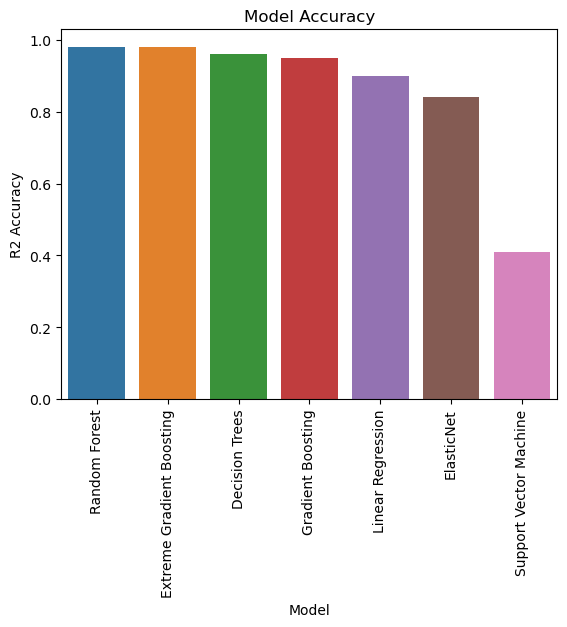

In [55]:
ax = sns.barplot(results.sort_values(by='R2 Accuracy', ascending=False), x='Model', y='R2 Accuracy')
ax.tick_params(axis='x', rotation=90)
plt.title ("Model Accuracy")
plt.ylabel('R2 Accuracy')
plt.xlabel('Model')